Now comes the final and most important step, the selection of the Modes. While the Iterative detrending retrieves a lot of periodicities not all of them are the ones we seek or can be seen in the data by eye. This is why this step is a very manual step which needs a lot of comparison with the raw data and some additional information plots.

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Periods = pd.read_csv("Example Data/Periods.csv")
NPZ = np.load("Example Data/Pre_detrended.npz")
Time = NPZ.get("Time")
Flux = NPZ.get("Flux")
FeatureMask = NPZ.get("FeatureMask")

<img src="Plots/Raw.png">

We additionaly plot the Periodogram of the X and Y position aswell as of the Background to see if the Periods we want to choose are actualy from other sources. We also plot a Periodogram of the window function. Where the window function is 1 at the time points where data is taken and 0 where there was no data taken.

In [3]:
from astropy.io import fits
from pathlib import Path

#### This part can be replaced with however you read in your data
Data_Path = Path("Example Data/MainExample.fits")
FITS = fits.open(Data_Path)
Dataset = FITS[1].data #Access the Data of the HDU BINTableHDU

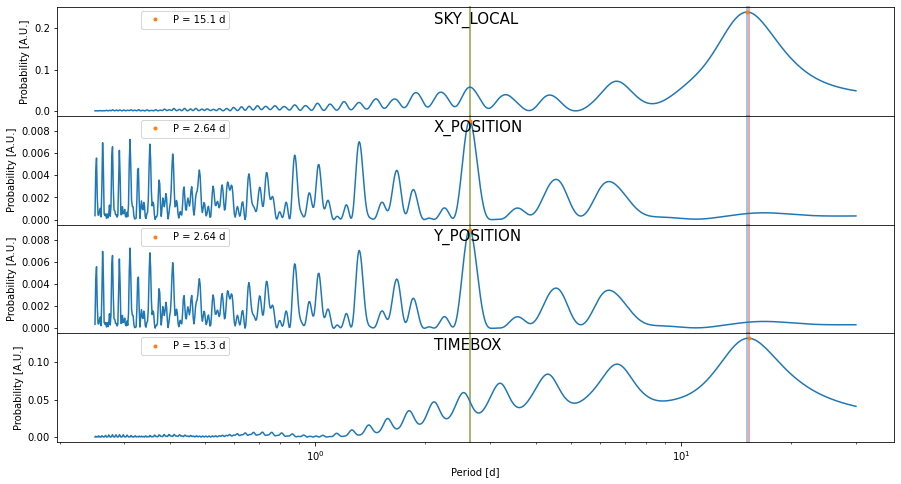

In [15]:
from TESS_Var import Calc_window_with_padding
from astropy.timeseries import LombScargle
import astropy.units as u




Curve_Names = ["SKY_LOCAL","X_POSITION","Y_POSITION","TIMEBOX"]

Time = Dataset["TIME"]
Data = {ID:Dataset[ID] for ID in Curve_Names[:-1]}

Data["TIMEBOX"],T = Calc_window_with_padding(Time)

periods = np.logspace(np.log10(0.25),np.log10(30),1000)*u.d
frequency = 1/periods

power_dict = {}
peak_dict = {}
n = 4
fig,ax = plt.subplots(n,1,figsize=(15,8),sharex=True)
plt.subplots_adjust(hspace=.0)


for i,ID in enumerate(Curve_Names):
    if ID == "TIMEBOX":
        power_dict[ID] = LombScargle(T*u.d,Data[ID]).power(frequency)
    else:
        power_dict[ID] = LombScargle(Time*u.d,Data[ID]).power(frequency)
    peak_dict[ID] = [np.argmax(power_dict[ID])]
    ax[i].plot(periods,power_dict[ID],"-",zorder=1)
    ax[i].plot(periods[peak_dict[ID][0]],power_dict[ID][peak_dict[ID][0]],".",zorder=2,label=f"P = {periods[peak_dict[ID][0]]:.3}")
    ax[i].text(0.45,0.85,ID,transform=ax[i].transAxes,size=15)
    ax[i].legend(loc=(0.1,0.8),fontsize=10)
    ax[i].semilogx()


colors = ["C0","C1","C2","C3","C4","C5"]
for i in range(n):
    for j in range(n):
        ax[j].axvline(x=periods[peak_dict[Curve_Names[i]]].value,c=colors[i],linewidth=2,zorder=0, alpha=0.4 ,clip_on=False)


for i in ax:
    i.set(xlabel="Period [d]",ylabel="Probability [A.U.]")


We now come to the most important part the selection of the Modes we do this manualy checking with the Raw data and the additional periodograms. We show a table of all the Periods and select the ones we trust in most up to a tertiary mode. We then overplot these periods over the pre detrended data, calculate a phase plot and overplot the periods on the Periodogram with lines at the P/2, P/3, 2 P and 3 P aliases. 

In [20]:
from ipysheet import from_dataframe,to_dataframe

DF_Periods = Periods
DF_Periods["Modes"] = np.zeros(len(DF_Periods.index),dtype=bool)
#The_DF = qgrid.show_grid(DF_Periods[["Modes","Period","Probability","False Alarm Probability","Amplitude","T0","off"]],)

sheet = from_dataframe(DF_Periods)
sheet

Sheet(cells=(Cell(column_end=0, column_start=0, numeric_format='0[.]0', row_end=25, row_start=0, squeeze_row=F…

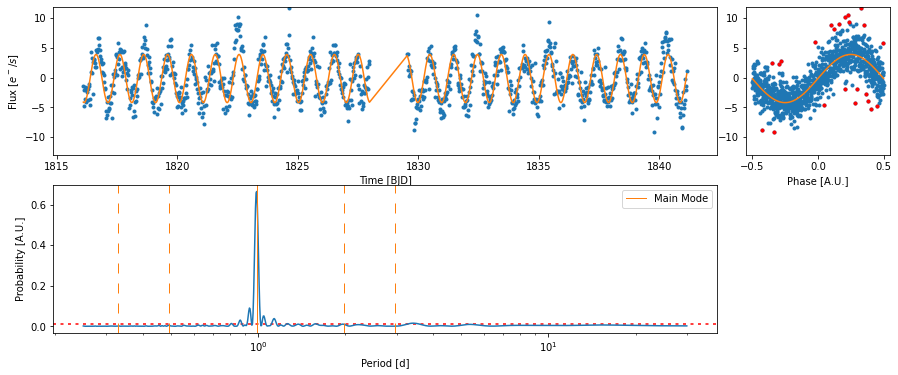

In [32]:
%matplotlib inline
from astropy.stats import sigma_clip
from PyAstronomy.pyTiming import pyPeriod
from PyAstronomy.pyasl import foldAt

#The Function that models the Sinus from the retrieved parameters
def sinmod(t,A,P,T0,off):
        return  A * np.sin(2*np.pi/P*(t-T0)) + off

#Read the Changed Dataframe fro ipysheets
Changed_DF = to_dataframe(sheet)
Modes_DF = Changed_DF.query("Modes == True").sort_values("Probability",ascending=False) #Get all the Rows with ticked boxes and sort them by Probabiliy


Colors = ["C1","C3","C6"]
Flux_Iter = Flux.copy() #Prepare a copy of the Pre-Detrended Flux so the main modes can be subtracted

Modes_Nr = Modes_DF.shape[0] #Check how many modes were selected
assert Modes_Nr <= 3 # Assert that there are only 3 Modes at max, the program is only written to deal with up to tertiary modes

color_modes = Colors
text_modes = ["Main Mode","Secondary Mode","3rd Mode"]

#Prepare the Figure for plotting
fig = plt.figure(figsize=(15,3+3*Modes_Nr))
gs = fig.add_gridspec(Modes_Nr+1,5)#number of selected modes + 1 subplot, last one is needed for the plotting of the periodogram
ax = np.empty((Modes_Nr,2),dtype=object)

#add subplots left for overplot and right for mode plots
for i in range(Modes_Nr):
    ax[i,0] = fig.add_subplot(gs[i,0:4])
    ax[i,1] = fig.add_subplot(gs[i,4:],sharey=ax[i,0])

ax2 = fig.add_subplot(gs[-1,0:4])

Clipped_Array,lowerbound,upperbound = sigma_clip(Flux,return_bounds=True)
total_y = upperbound-lowerbound
Masks = []

#for each mode
for i in range(Modes_Nr):
    #Calcuate the Sine Curve of the Mode
    Sin = sinmod(Time,Modes_DF.iloc[i]["Amplitude"],Modes_DF.iloc[i]["Period"],Modes_DF.iloc[i]["T0"],Modes_DF.iloc[i]["off"])
    phases = foldAt(Time, Modes_DF.iloc[i]["Period"], T0=Modes_DF.iloc[i]["T0"],centralzero=True) #Phase fold the data with the mode

    # Sort with respect to phase
    # First, get the order of indices ...
    sortIndi = np.argsort(phases)
    # ... and, second, rearrange the arrays.
    phases = phases

    flux = Flux_Iter

    Sine_phase = Modes_DF.iloc[i]["Amplitude"]*np.sin(2*np.pi*phases) + Modes_DF.iloc[i]["off"] #Calculate the Corresponding Sine Line
    Clip = sigma_clip(flux-Sine_phase,masked=True) #Mask the points that lie outside of 3 Sigma from the phase line 
    Msk = Clip.mask
    Masks.append(Msk)

    ax[i,1].plot(phases,flux,".")
    ax[i,1].plot(phases[Msk],flux[Msk],".r")
    ax[i,1].plot(phases[sortIndi],Sine_phase[sortIndi],color=Colors[i] )
    ax[i,1].set_xlabel("Phase [A.U.]")

    ax[i,0].plot(Time,Flux_Iter,".")
    ax[i,0].plot(Time,Sin,color=Colors[i])
    ax[i,0].set_ylabel("Flux [$e^-/s$]")
    ax[i,0].set_xlabel("Time [BJD]")
    ax[i,0].set_ylim(lowerbound - 0.1*total_y,upperbound + 0.1*total_y)
    
    #Subttract the Sine from the Pre-Detrended flux so we can check for the 2nd and 3rd mode better.
    Flux_Iter -= Sin

#Calculate the Periodogram again
periods = np.logspace(np.log10(0.25),np.log10(30),1000)*u.d
frequency = 1/periods
clp = pyPeriod.Gls((Time,Flux), freq = frequency.value,norm="ZK")
y_false = clp.powerLevel(0.5)

ax2.axhline(y_false,dashes=(2,3),color="r")#Plot horizontal line for the False alarm level
ax2.plot(1/clp.f,clp.p)

#plot the period line
for i,(_, Row_Sel) in enumerate(Modes_DF.iterrows()):
    
    ax2.axvline(Row_Sel["Period"],color=color_modes[i],alpha=1,linewidth = 1,label=text_modes[i])

    for j in range(2,4):
        ax2.axvline(j*Row_Sel["Period"] ,color=color_modes[i],alpha=1,dashes=(10,10),linewidth = 1)
        ax2.axvline(1/j*Row_Sel["Period"] ,color=color_modes[i],alpha=1,dashes=(10,10),linewidth = 1)
        
ax2.semilogx()
ax2.set_ylabel("Probability [A.U.]")
ax2.set_xlabel("Period [d]")
ax2.legend()

This usualy needs alot of back and forth until you are satisfied with the final selected periods.